In [4]:
import cv2
import numpy as np
import pickle
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

In [19]:
def get_relative_angle(R_abs, t_abs, R_est, t_est):
    # Create original vectors
    #v1 = np.array([.5, .5, .5])
    v1_t = np.squeeze(t_abs) #Absolute Direction
    #v2 = np.array([.5, .5, .5])
    v2_t = np.squeeze(t_est) #Estimated Direction
    dir_diff = np.arccos(np.dot(v1_t, v2_t)) #In Radian
    # v1_rot = np.dot(R_abs, v1) #Absolute Pose
    # v2_rot = np.dot(R_est, v2) #Estimated Pose
    pose_diff = np.arccos(np.dot(R_abs,R_est)) #In Radian
    return dir_diff, pose_diff
def visualize_diff(R_abs, t_abs, R_est, t_est, show=False):
    # Create original vectors
    v1 = np.array([.5, .5, .5])
    v1_t = np.squeeze(t_abs) #Absolute Direction
    v2 = np.array([.5, .5, .5])
    v2_t = np.squeeze(t_est) #Estimated Direction
    dir_diff = np.arccos(np.dot(v1_t, v2_t)) #In Radian
    #print("Directional Difference in Radian", dir_diff)
    #print(np.dot(v1_t,v2_t))
    # v3 = np.array([0, 0, 1])
    # Apply rotation matrix to vectors
    v1_rot = np.dot(R_abs, v1) #Absolute Pose
    v2_rot = np.dot(R_est, v2) #Estimated Pose
    pose_diff = np.arccos(np.dot(R_abs,R_est)) #In Radian
    #print("Pose Difference in Radian", pose_diff)
    #vv =
    # Plot original vectors and rotated vectors
    #ax.quiver(0, 0, 0, v1[0], v1[1], v1[2], color='r', label='Original Vector 1')
    # ax.quiver(0, 0, 0, v2[0], v2[1], v2[2], color='g', label='Original Vector 2')
    # ax.quiver(0, 0, 0, v3[0], v3[1], v3[2], color='b', label='Original Vector 3')
    if show:
        # Create 3D plot
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.quiver(0, 0, 0, v1_rot[0], v1_rot[1], v1_rot[2], color='r', linestyle='--', label='Absolute pose')
        ax.quiver(0, 0, 0, v2_rot[0], v2_rot[1], v2_rot[2], color='g', linestyle='--', label='Relative pose')
        ax.quiver(0, 0, 0, v1_t[0], v1_t[1], v1_t[2], color='b', linestyle='-', label='Absolute Direction')
        ax.quiver(0, 0, 0, v2_t[0], v2_t[1], v2_t[2], color='y', linestyle='-', label='Relative Direction')

        # Set plot limits and labels
        ax.set_xlim([-1, 1])
        ax.set_ylim([-1, 1])
        ax.set_zlim([-1, 1])
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')

        # Add legend and show plot
        ax.legend()
        plt.show()
    return pose_diff, dir_diff

def get_camera_mat(file):
    tree = ET.parse(file)
    root = tree.getroot()
    for x in  root.iter("Camera_Matrix"):
        for y in x.iter("data"):
            camera_mat = np.matrix(y.text)
    for x in  root.iter("Distortion_Coefficients"):
        for y in x.iter("data"):
            distort_mat = np.matrix(y.text)
    camera_mat = np.asarray(camera_mat.reshape((3,3)))
    distort_mat = np.asarray(distort_mat)
    #print(camera_mat, distort_mat)
    return [camera_mat, distort_mat]

def abs_relative_pose_from_transmat(mat1, mat2):
    T = np.dot(mat1, np.linalg.inv(mat2))
    R = T[:3, :3]
    t = T[:3, 3]
    #print(np.linalg.norm(t))
    t = t/np.linalg.norm(t)
    return np.asarray(R)
def abs_relative_direction_from_transmat(mat1, mat2):
    org = np.dot(np.linalg.inv(mat2),mat1)
    t_org = org[:3,3]/np.linalg.norm(org[:3,3])
    #org2 = np.dot(np.linalg.inv(mat1),mat2)
    #t_org2 = -org2[:3,3]/np.linalg.norm(org2[:3,3])
    return np.asarray(t_org)


def sift(img1, img2, show=False):
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    #gray2 = cv2.flip(gray2, 0)
    #gray1 = img1
    #gray2 = img2
    # Create SIFT object
    sift = cv2.SIFT.create(nfeatures = 0, nOctaveLayers=8 ,contrastThreshold = 0.02, edgeThreshold = 4,sigma = 1.6)

    # Detect keypoints and compute descriptors for both images
    kp1, des1 = sift.detectAndCompute(gray1, None)
    kp2, des2 = sift.detectAndCompute(gray2, None)

    # Match the descriptors using BFMatcher with default settings
    bf = cv2.BFMatcher(cv2.NORM_L2)
    matches = bf.knnMatch(des1, des2, k=2)
    #Flan Based
    # FLANN_INDEX_KDTREE = 1
    # index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    # search_params = dict(checks=50)
    # flann = cv2.FlannBasedMatcher(index_params,search_params)
    # matches = flann.knnMatch(des1,des2,k=2)
    # Filter out the matches based on the ratio test
    thres = 0.15
    for itr in range(2,5):
        good_matches = []
        for m, n in matches:
            if m.distance < thres * n.distance:
                good_matches.append(m)
        # Extract the keypoints from the good matches
        pts1 = np.float32([kp1[m.queryIdx].pt for m in good_matches])
        pts2 = np.float32([kp2[m.trainIdx].pt for m in good_matches])
        thres = 0.15*itr
        #print(thres)
        #print(pts1, thres)
        if len(pts1)>10:
            break
    # if len(pts1)<5:
    #     good_matches = []
    #     for m, n in matches:
    #         if m.distance < 0.8 * n.distance:
    #             good_matches.append(m)
    #
    #     # Extract the keypoints from the good matches
    #     pts1 = np.float32([kp1[m.queryIdx].pt for m in good_matches])
    #     pts2 = np.float32([kp2[m.trainIdx].pt for m in good_matches])
    #
    # print(len(pts1), len(pts2))

    #FOR VISUALIZING MATCHES
    if show:
        g_matches = []
        for m, n in matches:
            if m.distance < thres * n.distance:
                g_matches.append([m])
        img3 = cv2.drawMatchesKnn(gray1,kp1,gray2,kp2,g_matches,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
        plt.imshow(img3)
        plt.show()
    if len(pts1)<10:
        return pts1, pts2, False
    else:
        return pts1, pts2, True

def orb_fast(img1, img2):
    orb = cv2.ORB_create()
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    #img2 = cv2.flip(img2, 0)
    # Detect keypoints and compute descriptors for both images
    kp1, des1 = orb.detectAndCompute(img1, None)
    kp2, des2 = orb.detectAndCompute(img2, None)

    # Match descriptors using Brute-Force Matcher
    matches = bf.match(des1, des2)

    # Sort matches by distance
    good_matches = sorted(matches, key=lambda x: x.distance)
    #print(0.7*len(good_matches))
    good_matches = good_matches[:int(0.7*len(good_matches))]
    # Extract the keypoints from the good matches
    pts1 = np.float32([kp1[m.queryIdx].pt for m in good_matches])
    pts2 = np.float32([kp2[m.trainIdx].pt for m in good_matches])
    if len(pts1)<10:
        return pts1, pts2, False
    else:
        return pts1, pts2, True

def estimate_relative_pose(img1, img2, K, D, show=False, method = "sift"):
    # # Load the two images
    img1 = cv2.imread(img1)
    img2 = cv2.imread(img2)
    # dim = (102,136)
    # img1 = cv2.resize(img1, dim, interpolation = cv2.INTER_AREA)
    # img2 = cv2.resize(img2, dim, interpolation = cv2.INTER_AREA)
    if method == "sift":
        pts1, pts2, is_matched = sift(img1, img2, show)
    if method == "orb":
        pts1, pts2, is_matched = orb_fast(img1, img2)
    # pts1 = np.int32(pts1)
    # pts2 = np.int32(pts2)
    # print(type(pts1), len(pts1), pts1.shape)
    # pts_red_1 = []
    # pts_red_2= []
    # for idx in range(len(pts1)):
    #     if 1050>pts1[idx][0]>250 and 800>pts1[idx][1]>200:
    #         pts_red_1.append(pts1[idx])
    #     if 1050>pts2[idx][0]>250 and 800>pts2[idx][1]>200:
    #         pts_red_2.append(pts2[idx])
    # pts1 = np.asarray(pts_red_1)
    # pts2 = np.asarray(pts_red_2)
    # min_val = min(len(pts1), len(pts2))
    # pts1 = pts1[:min_val,:]
    # pts2 = pts2[:min_val,:]
    # Compute the Essential matrix using RANSAC
    #If Flan used
    #E, mask = cv2.findEssentialMat(pts1, pts2, K,  cv2.FM_LMEDS)
    #E, mask = cv2.findEssentialMat(pts1,pts2, K, method=cv2.RANSAC, maxIters=100000)
    if is_matched:
        E, mask  = cv2.findEssentialMat(points1=pts1, points2=pts2, cameraMatrix1=K, distCoeffs1=D, cameraMatrix2=K, distCoeffs2=D, method=cv2.RANSAC, prob = 0.99999, threshold = 1)
        F, _ = cv2.findFundamentalMat(pts1, pts2, 3)
        print(F)
    #E, mask  = cv2.findEssentialMat(points1=pts1, points2=pts2, cameraMatrix1=K, distCoeffs1=D, cameraMatrix2=K, distCoeffs2=D, method=cv2.RANSAC)
    # Decompose the Essential matrix into the rotation and translation matrices
        E1 = K.T*F*K
        _, R, t, _ = cv2.recoverPose(E1, pts1, pts2, K)
    # The relative pose between the two images can be represented as a 3x4 matrix [R | t]
    #print(mask.shape)
        return np.asarray(R),np.asarray(t), True
    else:
        print("MINIMUM 5 POINT SHOULD BE MATCHED")
        return False, False, False

PR_20141102_074954_230_LC16.pngPR_20141102_074955_732_LC16.png
[[-0.6513932  -0.58034927 -0.48875518 39.75346353]
 [-0.74991552  0.59040702  0.29840621 73.73233388]
 [ 0.11538466  0.56090487 -0.81980004  6.61055763]
 [ 0.          0.          0.          1.        ]] [[-0.69789    -0.4882998  -0.52393974 38.42260178]
 [-0.7045719   0.59940013  0.37986567 72.13313198]
 [ 0.12856121  0.63425767 -0.76235767  7.89901564]
 [ 0.          0.          0.          1.        ]]


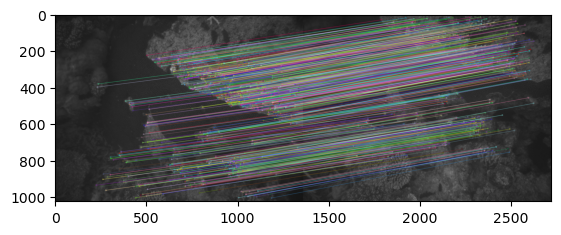

[[-2.59585414e-08  8.55088314e-07  8.44407990e-04]
 [-6.19515441e-07  3.69682608e-07  4.94876694e-03]
 [-6.86432083e-04 -5.49916449e-03  1.00000000e+00]]
0.433148454136587 [[0.10901732 1.65010807 1.49615765]
 [1.49199877 1.52020688 3.04789642]
 [1.49561524 0.09412981 1.51426198]]


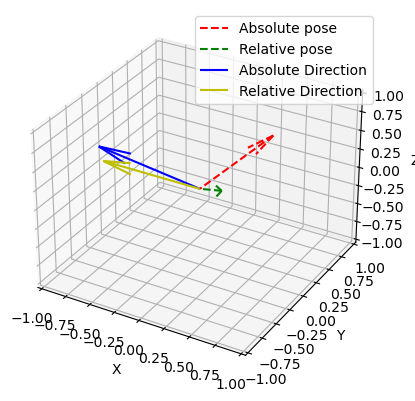

In [20]:
calib_file = "/home/turin/Desktop/lizard_dataset_curated/opencv_cam_calib.xml"
img_path = "/home/turin/Desktop/lizard_island/jackson/chronological/2014/r20141102_074952_lizard_d2_081_horseshoe_circle01/081_photos/"
K, D = get_camera_mat(calib_file)
# img1 = "/home/turin/Desktop/lizard_jackson/chronological/2014/r20141102_074952_lizard_d2_081_horseshoe_circle01/081_photos/PR_20141102_074954_230_LC16.png"
# img2 = "/home/turin/Desktop/lizard_jackson/chronological/2014/r20141102_074952_lizard_d2_081_horseshoe_circle01/081_photos/PR_20141102_074954_730_LC16.png"
# img3 = "/home/turin/Desktop/lizard_jackson/chronological/2014/r20141102_074952_lizard_d2_081_horseshoe_circle01/081_photos/PR_20141102_074955_231_LC16.png"
# img4 = "/home/turin/Desktop/lizard_jackson/chronological/2014/r20141102_074952_lizard_d2_081_horseshoe_circle01/081_photos/PR_20141102_074955_732_LC16.png"
# img5 = "/home/turin/Desktop/lizard_island/jackson/chronological/2014/r20141102_074952_lizard_d2_081_horseshoe_circle01/081_photos/PR_20141102_074956_734_LC16.png"
#sift_pose = np.vstack((np.hstack((R,t)),[0,0,0,1]))
file = open("/home/turin/Documents/GitHub/long_term_underwater_vision/dataset/dataset_positive", 'rb')
im, label  = pickle.load(file)
file.close()
idx = 2
print(im[idx][0]+im[idx][1])
img1 = img_path+im[idx][0]
img2 = img_path+im[idx][1]
mat1 = label[idx][1][0]
mat2 = label[idx][1][1]
print(mat1, mat2)
R_est, t_est, is_availed= estimate_relative_pose(img1,img2,K, D, show=True, method = "sift")
R_abs = abs_relative_pose_from_transmat(mat1,mat2)
t_abs = abs_relative_direction_from_transmat(mat1,mat2)
pdiff, tdiff = get_relative_angle(R_abs, t_abs, R_est, t_est)
print(pdiff, tdiff)
if is_availed:
    x, y = visualize_diff(R_abs,t_abs,R_est,t_est, show=True)
    #print(x,y)
# R_abs - R_est, np.sum(np.abs(R_abs - R_est))/9

In [19]:
from long_term_underwater_vision.model import sift_pose_est

ModuleNotFoundError: No module named 'long_term_underwater_vision'

In [190]:
image_id_pos = im
label_pos = label
assert len(image_id_pos)==len(label_pos), f"image pair and label length must be same"

In [224]:
img_path = "/home/turin/Desktop/lizard_island/jackson/chronological/2014/r20141102_074952_lizard_d2_081_horseshoe_circle01/081_photos/"
trans_error = []
rot_error = []
im_curated = []
label_curated = []
for x in range(len(image_id_pos)):
    if x%100==0:
        print(x)
    img1 = img_path+image_id_pos[x][0]
    img2 = img_path+image_id_pos[x][1]
    mat1 = label_pos[x][1][0]
    mat2 = label_pos[x][1][1]
    check = [image_id_pos[x][0],image_id_pos[x][1]]
    R_est, t_est, is_availed= estimate_relative_pose(img1,img2,K, D,show=False, method="sift")
    R_abs = abs_relative_pose_from_transmat(mat1,mat2)
    t_abs = abs_relative_direction_from_transmat(mat1,mat2)
    if is_availed:
        r_diff, t_diff = visualize_diff(R_abs,t_abs,R_est,t_est, show=False)
        trans_error.append([img1, img2,t_diff])
        rot_error.append(r_diff)
        if r_diff<0.5 and t_diff<0.5:
            im_curated.append(image_id_pos[x])
            label_curated.append(label_pos[x])

len(im_curated), len(label_curated)
data_set = (im_curated, label_curated)
file = open('dataset_curated', 'wb')
pickle.dump(data_set, file)
file.close()

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300


In [250]:
im_curated[10:100]

[['PR_20141102_074954_730_LC16.png', 'PR_20141102_074956_734_LC16.png'],
 ['PR_20141102_074955_231_LC16.png', 'PR_20141102_074954_230_LC16.png'],
 ['PR_20141102_074955_231_LC16.png', 'PR_20141102_074954_730_LC16.png'],
 ['PR_20141102_074955_231_LC16.png', 'PR_20141102_074955_732_LC16.png'],
 ['PR_20141102_074955_231_LC16.png', 'PR_20141102_074956_233_LC16.png'],
 ['PR_20141102_074955_231_LC16.png', 'PR_20141102_074956_734_LC16.png'],
 ['PR_20141102_074955_231_LC16.png', 'PR_20141102_074957_235_LC16.png'],
 ['PR_20141102_074955_231_LC16.png', 'PR_20141102_080240_746_LC16.png'],
 ['PR_20141102_074955_231_LC16.png', 'PR_20141102_080241_247_LC16.png'],
 ['PR_20141102_074955_732_LC16.png', 'PR_20141102_074954_230_LC16.png'],
 ['PR_20141102_074955_732_LC16.png', 'PR_20141102_074954_730_LC16.png'],
 ['PR_20141102_074955_732_LC16.png', 'PR_20141102_074955_231_LC16.png'],
 ['PR_20141102_074955_732_LC16.png', 'PR_20141102_074956_734_LC16.png'],
 ['PR_20141102_074955_732_LC16.png', 'PR_20141102_0

In [5]:
file = open('dataset_curated', 'rb')
x1 , y1 = pickle.load(file)
file.close()

5398

74
[[ 0.585449    0.75581303 -0.29325097]
 [-0.77266661  0.62969964  0.08040314]
 [ 0.24542977  0.1795133   0.95264852]]
Recover Pose: [[-0.63225246 -0.77475047  0.00430498]
 [ 0.77157169 -0.63014267 -0.08716275]
 [ 0.07024213 -0.05178726  0.99618478]] [[ 0.14666201]
 [ 0.00343102]
 [-0.98918071]]


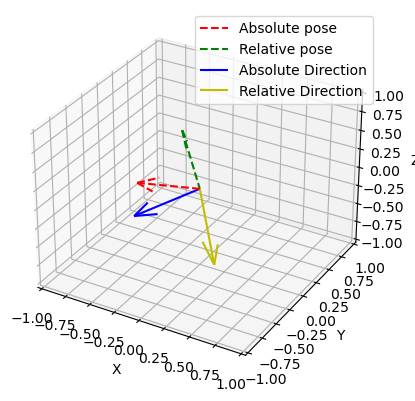

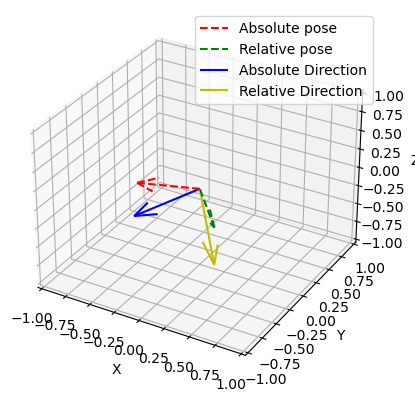

(0.8135530622656177, 0.9517276135124081)

In [175]:
# R_est, t_est, D = estimate_relative_pose(img_path+im[idx][0],img_path+im[idx][1],K, D)
# print(D[0])
# mat1 = label[idx][1][0]
# mat2 = label[idx][1][1]
# R_abs = abs_relative_pose_from_transmat(mat1,mat2)
# t_abs = abs_relative_direction_from_transmat(mat1,mat2)
# print("Recover Pose:", R_est, t_est)
# visualize_diff(R_abs,t_abs,R_est,t_est, show=True)
# visualize_diff(R_abs,t_abs,D[0],t_est, show=True)